In [87]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet


In [88]:
import numpy as np 
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from ast import literal_eval
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import warnings; warnings.simplefilter('ignore')

def weighted_rating(x, m, C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

def filter_keywords(x, s):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

cols = ['id', 'movieId', 'title', 'genres', 'description', 'keywords', \
        'cast', 'director', 'spoken_languages', 'production_companies',\
        'production_countries', 'popularity', 'year', 'vote_average',\
         'vote_count', 'wr']

def read_dataset(metadata_path, links_small_path, credits_path,keywords_path):
    meta = pd.read_csv(metadata_path)
    links_small = pd.read_csv(links_small_path)
    credits = pd.read_csv(credits_path)
    keywords = pd.read_csv(keywords_path)
    return meta, links_small, credits, keywords

def cal_weighted_rating(meta, percentile=0.95):
    vote_counts = meta[meta['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = meta[meta['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)

    meta = meta[(meta['vote_count'].notnull()) \
                     & (meta['vote_average'].notnull())]
    meta['vote_count'] = meta['vote_count'].astype('int')
    meta['vote_average'] = meta['vote_average'].astype('int')
    meta['wr'] = meta.apply(lambda x: weighted_rating(x, m, C), axis=1)

    return meta
    
def movie_feature(metadata_path, links_small_path, credits_path,keywords_path, \
                  percentile=0.95, more_weight_on = None, \
                    stemmer = SnowballStemmer('english'), cols=cols):
    # read dataset
    meta, links_small, credits, keywords = read_dataset(metadata_path, \
        links_small_path, credits_path,keywords_path)

    # change type + drop
    links_small = links_small[links_small['tmdbId'].notnull()]
    links_small['tmdbId'] = links_small['tmdbId'].astype('int')

    meta = meta.drop([19730, 29503, 35587])
    meta['popularity'] = meta[meta['popularity'].notnull()]['popularity'].astype('float')
    meta['id'] = meta['id'].astype('int')
    meta['year'] = pd.to_datetime(meta['release_date'], errors='coerce').apply(\
        lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
    meta = meta[meta.production_companies.notnull()]
    keywords['id'] = keywords['id'].astype('int')
    credits['id'] = credits['id'].astype('int')

    # calcualte weighted rating for movies
    meta = cal_weighted_rating(meta)

    # merge meta + link small => create a smaller dataset for recommend
    smd = meta[meta['id'].isin(links_small['tmdbId'])]

    # create description feature
    smd['tagline'] = smd['tagline'].fillna('')
    smd['description'] = smd['overview'] + smd['tagline']
    smd['description'] = smd['description'].fillna('')
    
    # merge credit + keywords + links_small
    smd = smd.merge(credits, on='id')
    smd = smd.merge(keywords, on='id')
    smd = smd.merge(links_small, left_on='id', right_on='tmdbId')

    # feature engineering
    literal_features = ['cast', 'spoken_languages', 'genres', 'keywords',\
                        'production_companies', 'production_countries']
    for fearture in literal_features:
        smd[fearture] = smd[fearture].apply(literal_eval)
        smd[fearture] = smd[fearture].apply(lambda x: [i['name'] \
                                            for i in x] if isinstance(x, list) else [])
    smd['crew'] = smd['crew'].apply(literal_eval)
    smd['director'] = smd['crew'].apply(get_director)

    # top 3 actors
    smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
   
    # Strip Spaces and Convert to Lowercase 
    smd['cast'] = smd['cast'].apply(lambda x: [str.lower(\
        i.replace(" ", "")) for i in x])
    smd['director'] = smd['director'].astype('str').apply(\
        lambda x: str.lower(x.replace(" ", "")))
    if more_weight_on:
        smd[more_weight_on] = smd[more_weight_on].apply(lambda x: [x,x,x])
    
    # choose keywords appear more than once + stemming
    s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
    s = s.value_counts()
    s = s[s > 1]
    smd['keywords'] = smd['keywords'].apply(lambda x: filter_keywords(x, s))
    smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
    smd['keywords'] = smd['keywords'].apply(lambda x: \
                                            [str.lower(i.replace(" ", "")) for i in x])

    return smd[cols]
    


In [89]:
credits_ = r'/kaggle/input/the-movies-dataset/credits.csv'
keywords = r'/kaggle/input/the-movies-dataset/keywords.csv'
links = r'/kaggle/input/the-movies-dataset/links_small.csv'
movies_metadata = r'/kaggle/input/the-movies-dataset/movies_metadata.csv'
smd = movie_feature(movies_metadata, links, credits_, keywords, more_weight_on='director')
# print(smd.columns)

In [90]:
smd["description"] = smd["description"] + " " + \
    smd["title"] + " " + \
    smd['keywords'].apply(lambda x: " ".join(map(str, x))) + " " + \
    smd['production_companies'].apply(lambda x: " ".join(map(str, x))) 
#     smd['genres'].apply(lambda x: " ".join(map(str, x))) + " " + \
#     smd['cast'].apply(lambda x: " ".join(map(str, x))) + " " + \
#     smd['director'].apply(lambda x: " ".join(map(str, x))) + " " + \
#     smd['spoken_languages'].apply(lambda x: " ".join(map(str, x))) + " " + \
#     smd['production_countries'].apply(lambda x: " ".join(map(str, x)))

In [91]:
smd

,id,movieId,title,genres,description,keywords,cast,director,spoken_languages,production_companies,production_countries,popularity,year,vote_average,vote_count,wr
0,862,1,Toy Story,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...","[jealousi, toy, boy, friendship, friend, rival...","[tomhanks, timallen, donrickles]","[johnlasseter, johnlasseter, johnlasseter]",[English],[Pixar Animation Studios],[United States of America],21.946943,1995,7,5415,6.869770
1,8844,2,Jumanji,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,"[boardgam, disappear, basedonchildren'sbook, n...","[robinwilliams, jonathanhyde, kirstendunst]","[joejohnston, joejohnston, joejohnston]","[English, Français]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],17.015539,1995,6,2413,5.884891
2,15602,3,Grumpier Old Men,"[Romance, Comedy]",A family wedding reignites the ancient feud be...,"[fish, bestfriend, duringcreditssting]","[waltermatthau, jacklemmon, ann-margret]","[howarddeutch, howarddeutch, howarddeutch]",[English],"[Warner Bros., Lancaster Gate]",[United States of America],11.712900,1995,6,92,5.376968
3,31357,4,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...","[basedonnovel, interracialrelationship, single...","[whitneyhouston, angelabassett, lorettadevine]","[forestwhitaker, forestwhitaker, forestwhitaker]",[English],[Twentieth Century Fox Film Corporation],[United States of America],3.859495,1995,6,34,5.299755
4,11862,5,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,"[babi, midlifecrisi, confid, age, daughter, mo...","[stevemartin, dianekeaton, martinshort]","[charlesshyer, charlesshyer, charlesshyer]",[English],"[Sandollar Productions, Touchstone Pictures]",[United States of America],8.387519,1995,5,173,5.175099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9214,159550,161944,The Last Brickmaker in America,[Drama],A man must cope with the loss of his wife and ...,[friendship],"[sidneypoitier, wendycrewson, jayo.sanders]","[greggchampion, greggchampion, greggchampion]",[],[Nasser Entertainment],[United States of America],0.038998,2001,7,1,5.248931
9215,392572,162542,Rustom,"[Thriller, Romance]","Rustom Pavri, an honourable officer of the Ind...",[bollywood],"[akshaykumar, ileanad'cruz, eshagupta]","[tinusureshdesai, tinusureshdesai, tinusureshd...",[हिन्दी],[KriArj Entertainment],[India],7.333139,2016,7,25,5.340490
9216,402672,162672,Mohenjo Daro,"[Adventure, Drama, History, Romance]","Village lad Sarman is drawn to big, bad Mohenj...",[bollywood],"[hrithikroshan, poojahegde, kabirbedi]","[ashutoshgowariker, ashutoshgowariker, ashutos...",[हिन्दी],"[UTV Motion Pictures, Ashutosh Gowariker Produ...",[India],1.423358,2016,6,26,5.287576
9217,315011,163056,Shin Godzilla,"[Action, Adventure, Drama, Horror, Science Fic...",From the mind behind Evangelion comes a hit la...,"[monster, godzilla, giantmonst, destruct, kaiju]","[hirokihasegawa, yutakatakenouchi, satomiishih...","[hideakianno, hideakianno, hideakianno]","[Italiano, Deutsch, English, 日本語]","[Cine Bazar, Toho Pictures]",[Japan],9.285519,2016,6,152,5.440760


In [92]:
smd["description"][0]

"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences. Toy Story jealousi toy boy friendship friend rivalri boynextdoor newtoy toycomestolif Pixar Animation Studios"

In [93]:
smd = smd[['id', 'movieId', 'title', 'description']]
smd = smd.drop_duplicates()

In [94]:
smd

,id,movieId,title,description
0,862,1,Toy Story,"Led by Woody, Andy's toys live happily in his ..."
1,8844,2,Jumanji,When siblings Judy and Peter discover an encha...
2,15602,3,Grumpier Old Men,A family wedding reignites the ancient feud be...
3,31357,4,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom..."
4,11862,5,Father of the Bride Part II,Just when George Banks has recovered from his ...
...,...,...,...,...
9214,159550,161944,The Last Brickmaker in America,A man must cope with the loss of his wife and ...
9215,392572,162542,Rustom,"Rustom Pavri, an honourable officer of the Ind..."
9216,402672,162672,Mohenjo Daro,"Village lad Sarman is drawn to big, bad Mohenj..."
9217,315011,163056,Shin Godzilla,From the mind behind Evangelion comes a hit la...


### TF-IDF

In [95]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])
tfidf_matrix

<9082x365886 sparse matrix of type '<class 'numpy.float64'>'
	with 778229 stored elements in Compressed Sparse Row format>

In [96]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [97]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [98]:
cosine_sim.shape

(9082, 9082)

In [99]:
smd = smd.reset_index()
smd = smd.drop(columns='index')
movie_ids = smd['movieId']
indices = pd.Series(smd.index, index=smd['movieId'])

## Evaluate

In [100]:
train_df = pd.read_csv('/kaggle/input/train-set-from-ratings/train_set.csv')

In [101]:
train_df

,userId,movieId,rating,timestamp
0,431,2863,4.0,1165548515
1,571,7173,2.0,1334343358
2,77,223,4.5,1163004353
3,580,1032,4.0,1165291033
4,624,1221,5.0,1019124147
...,...,...,...,...
74998,547,5810,3.0,1415444349
74999,418,1835,4.0,1132180632
75000,5,33679,4.0,1163374517
75001,358,905,5.0,957479957


In [102]:
def get_top_n_similar(recommended, movie, cosine_sim, n_rec = 10):
    try:
        idx = indices[movie]
    except:
        # In case movie is not available in cosine_sim (or not in metadata)
        pass
    else:
        # top 10 most similar
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:n_rec+1]

        for movie_rec in sim_scores:
            # change index -> movieId
            movie_recommended = (movie_ids.iloc[movie_rec[0]], movie_rec[1])
            recommended.append(movie_recommended)
    return recommended

In [103]:
def get_recommendations(user_id, cosine_sim, n_rec = 10):
    movies_id = train_df[train_df.userId == user_id].movieId 
    recommended = []
    for movie in movies_id:
        recommended = get_top_n_similar(recommended, movie, cosine_sim, n_rec = 10)
            
    # create a DataFrame to store all movies recommended            
    recommended = pd.DataFrame(recommended)  
    recommended.columns = ['movieId', 'sim']
    
    recommended = recommended[~recommended['movieId'].isin(movies_id)].groupby('movieId').max().reset_index()
    recommended = recommended.sort_values('sim')[::-1].head(n_rec)
    recommended['userId'] = user_id
    return recommended.drop(columns='sim')


Lỗi ở đây là chưa drop những movieId mà user đã rate
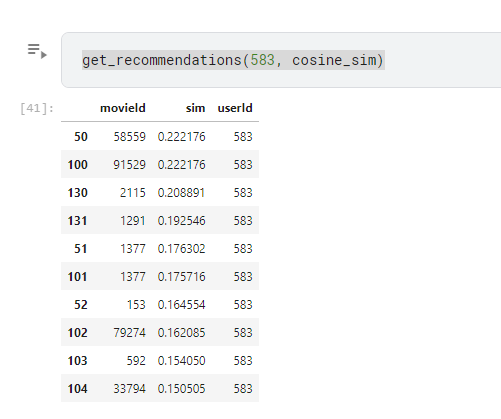

In [104]:
def full_recommend(df, cosine_sim):
    rec_df = pd.DataFrame()
    for user in df.userId.value_counts().index:
        rec_df = pd.concat([rec_df, get_recommendations(user, cosine_sim)])
    return rec_df

### Example

In [105]:
train_df

,userId,movieId,rating,timestamp
0,431,2863,4.0,1165548515
1,571,7173,2.0,1334343358
2,77,223,4.5,1163004353
3,580,1032,4.0,1165291033
4,624,1221,5.0,1019124147
...,...,...,...,...
74998,547,5810,3.0,1415444349
74999,418,1835,4.0,1132180632
75000,5,33679,4.0,1163374517
75001,358,905,5.0,957479957


In [106]:
smd[smd.title == 'The Dark Knight']

,id,movieId,title,description
6897,155,58559,The Dark Knight,Batman raises the stakes in his war on crime. ...


In [107]:
recommend_for_film = get_top_n_similar([], 58559, cosine_sim)
recommend_for_film

[(91529, 0.2557467822965026),
 (33794, 0.2162962058597865),
 (99813, 0.18414277537861665),
 (79274, 0.1765133273684507),
 (1377, 0.1693171960667285),
 (98124, 0.15089895691320623),
 (153, 0.14419885975713675),
 (592, 0.14258716677420982),
 (3213, 0.14255349365283254),
 (136864, 0.12915887083612615)]

In [108]:
smd[smd["movieId"].isin(pd.DataFrame(get_top_n_similar([], 58559, cosine_sim))[0])]

,id,movieId,title,description
132,414,153,Batman Forever,The Dark Knight of Gotham City confronts a das...
524,268,592,Batman,The Dark Knight of Gotham City begins his war ...
1113,364,1377,Batman Returns,"Having defeated the Joker, Batman now faces th..."
2578,14919,3213,Batman: Mask of the Phantasm,An old flame of Bruce Wayne's strolls into tow...
6141,272,33794,Batman Begins,"Driven by tragedy, billionaire Bruce Wayne ded..."
7561,40662,79274,Batman: Under the Red Hood,Batman faces his ultimate challenge as the mys...
7926,49026,91529,The Dark Knight Rises,Following the death of District Attorney Harve...
8160,123025,98124,"Batman: The Dark Knight Returns, Part 1",Batman has not been seen for ten years. A new ...
8222,142061,99813,"Batman: The Dark Knight Returns, Part 2",Batman has stopped the reign of terror that Th...
8905,209112,136864,Batman v Superman: Dawn of Justice,Fearing the actions of a god-like Super Hero l...


In [109]:
train_df[train_df['movieId'] == 58559]

,userId,movieId,rating,timestamp
514,106,58559,5.0,1216958340
747,91,58559,5.0,1448798116
836,630,58559,3.0,1443808760
1596,62,58559,5.0,1475948734
1819,622,58559,5.0,1424224970
...,...,...,...,...
68393,355,58559,5.0,1231028576
68412,601,58559,4.5,1270254671
70937,379,58559,4.0,1378179986
71698,46,58559,5.0,1366390187


In [110]:
for user in train_df[train_df['movieId'] == 58559]['userId']:
    print(user, ': ', train_df[train_df['userId'] == user].shape[0])

106 :  34
91 :  113
630 :  17
62 :  40
622 :  23
473 :  57
136 :  37
3 :  38
457 :  535
273 :  69
478 :  56
362 :  89
244 :  55
546 :  49
176 :  192
547 :  1793
203 :  28
566 :  17
94 :  147
600 :  26
423 :  260
213 :  683
454 :  20
384 :  364
152 :  164
250 :  116
352 :  63
524 :  48
572 :  79
426 :  191
97 :  96
570 :  96
212 :  657
632 :  29
483 :  89
392 :  19
456 :  50
125 :  157
275 :  152
388 :  594
402 :  239
26 :  129
563 :  119
42 :  53
481 :  327
574 :  256
623 :  77
365 :  52
277 :  43
580 :  691
378 :  110
138 :  61
104 :  57
101 :  41
316 :  105
450 :  90
199 :  316
660 :  69
479 :  74
56 :  392
61 :  124
624 :  1301
542 :  47
380 :  797
503 :  33
255 :  109
298 :  56
583 :  15
515 :  25
287 :  190
314 :  25
72 :  143
615 :  289
297 :  104
226 :  27
324 :  113
13 :  40
270 :  172
149 :  173
31 :  52
186 :  32
521 :  37
355 :  231
601 :  35
379 :  53
46 :  29
147 :  28


Choose user 583, 630 to take example due to the small number of films they watched

In [111]:
get_recommendations(583, cosine_sim)

,movieId,userId
25,2115,583
81,33794,583
14,1291,583
121,99813,583
111,79274,583
94,59615,583
16,1377,583
4,153,583
118,98124,583
34,3213,583


Note: nếu df kết quả có cả consine similarity \
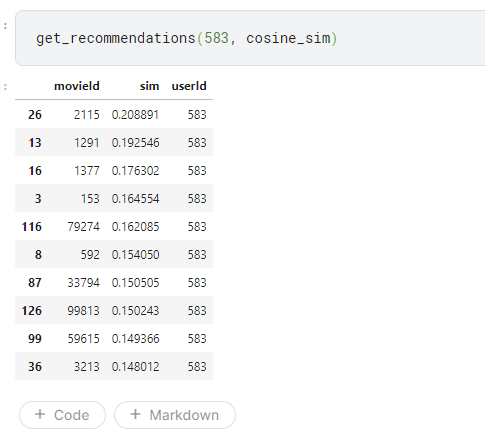

In [112]:
get_recommendations(630, cosine_sim)

,movieId,userId
46,3114,630
145,91529,630
141,78499,630
119,33794,630
95,6934,630
151,99813,630
142,79274,630
18,1377,630
89,6365,630
149,98124,630


In [113]:
recommended_df = full_recommend(train_df, cosine_sim)

In [114]:
recommended_df

,movieId,userId
3730,50742,547
2446,5675,547
2686,6564,547
1238,2647,547
247,443,547
...,...,...
55,3450,484
32,1632,484
19,852,484
127,70188,484


In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_data(rating_df):
    train_df, test_df = train_test_split(rating_df, \
                                         test_size=0.2, stratify=rating_df['userId'], \
                                        random_state=42)
    return train_df, test_df

def check_movieId(pred_df, val_df):
    result = pred_df['movieId'].isin(val_df[val_df['userId'] == \
                                   pred_df['userId'].iloc[0]]['movieId'])
    return result.reset_index(drop=True)

def evaluate(pred_df, val_df):
    """ Proportion of movies recommended that were actually watched by users

    Args:
    pred_df: dataframe, 2 columns: userId, movieId
    val_df: dataframe, 2 columns: userId, movieId

    Returns:
    
    """
    result = pred_df.groupby('userId').apply(lambda x: check_movieId(x, val_df))
    result = result.groupby('userId').sum() / result.groupby('userId').count()

    return result.mean().mean()


    

In [116]:
testset = pd.read_csv(r'/kaggle/input/train-set-from-ratings/test_set.csv')

In [117]:
testset = testset[['userId', 'movieId']]
testset

,userId,movieId
0,302,593
1,191,110
2,457,5337
3,239,1042
4,292,5377
...,...,...
24996,353,34319
24997,428,743
24998,595,1097
24999,664,61248


In [118]:
evaluate(recommended_df, testset)

0.0760059612518629

### Count Vectorize

In [119]:
count_vec = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_vec_matrix = count_vec.fit_transform(smd['description'])
count_vec_matrix

<9082x365886 sparse matrix of type '<class 'numpy.int64'>'
	with 778229 stored elements in Compressed Sparse Row format>

In [120]:
count_cosine_sim = cosine_similarity(count_vec_matrix, count_vec_matrix)
count_cosine_sim

array([[1.        , 0.00893178, 0.        , ..., 0.        , 0.        ,
        0.01558936],
       [0.00893178, 1.        , 0.01913459, ..., 0.00910032, 0.01709652,
        0.02276585],
       [0.        , 0.01913459, 1.        , ..., 0.01001252, 0.00940513,
        0.        ],
       ...,
       [0.        , 0.00910032, 0.01001252, ..., 1.        , 0.00894606,
        0.        ],
       [0.        , 0.01709652, 0.00940513, ..., 0.00894606, 1.        ,
        0.00745999],
       [0.01558936, 0.02276585, 0.        , ..., 0.        , 0.00745999,
        1.        ]])

In [121]:
smd[smd["movieId"].isin(pd.DataFrame(get_top_n_similar([], 58559, count_cosine_sim))[0])]

,id,movieId,title,description
132,414,153,Batman Forever,The Dark Knight of Gotham City confronts a das...
524,268,592,Batman,The Dark Knight of Gotham City begins his war ...
1113,364,1377,Batman Returns,"Having defeated the Joker, Batman now faces th..."
2578,14919,3213,Batman: Mask of the Phantasm,An old flame of Bruce Wayne's strolls into tow...
6141,272,33794,Batman Begins,"Driven by tragedy, billionaire Bruce Wayne ded..."
7561,40662,79274,Batman: Under the Red Hood,Batman faces his ultimate challenge as the mys...
7926,49026,91529,The Dark Knight Rises,Following the death of District Attorney Harve...
8160,123025,98124,"Batman: The Dark Knight Returns, Part 1",Batman has not been seen for ten years. A new ...
8222,142061,99813,"Batman: The Dark Knight Returns, Part 2",Batman has stopped the reign of terror that Th...
8905,209112,136864,Batman v Superman: Dawn of Justice,Fearing the actions of a god-like Super Hero l...


In [122]:
# compare with cosine_sim (tf-idf)
cosine_sim

array([[1.00000000e+00, 4.67082376e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 5.06830916e-03],
       [4.67082376e-03, 1.00000000e+00, 1.15645213e-02, ...,
        5.00292570e-04, 1.80735563e-03, 4.52488641e-03],
       [0.00000000e+00, 1.15645213e-02, 1.00000000e+00, ...,
        1.24478976e-03, 1.72048806e-03, 0.00000000e+00],
       ...,
       [0.00000000e+00, 5.00292570e-04, 1.24478976e-03, ...,
        1.00000000e+00, 4.87674112e-04, 0.00000000e+00],
       [0.00000000e+00, 1.80735563e-03, 1.72048806e-03, ...,
        4.87674112e-04, 1.00000000e+00, 1.12209229e-03],
       [5.06830916e-03, 4.52488641e-03, 0.00000000e+00, ...,
        0.00000000e+00, 1.12209229e-03, 1.00000000e+00]])

In [123]:
count_vectorized_recommended_df = full_recommend(train_df, count_cosine_sim)

In [124]:
evaluate(count_vectorized_recommended_df, testset)

0.06616989567809241